# Load the necessary packages

In [1]:
#Neural Networks
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from skimage import io, transform

#Matplotlib
import matplotlib.pyplot as plt
import numpy as np

#For image processing and the Dataset class
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from skimage import io, transform
from PIL import Image

#CSV and File management
import os
import pandas as pd

#Display matplotlib within jupyter notebook
plt.ion()

In [2]:
data_folder = os.path.join(os.getcwd(), "data")

train_df = pd.read_csv(os.path.join(data_folder, "Train.csv"))
test_df  = pd.read_csv(os.path.join(data_folder, "Test.csv" ))

# The following cell plots all Pokemon of a given Pokedex number, specified from a csv dataframe

Note: it also returns a dataframe of the specified pokemon and their labels + dexnum

[32, 33, 34, 35, 36, 37, 38, 39, 40, 41]
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)


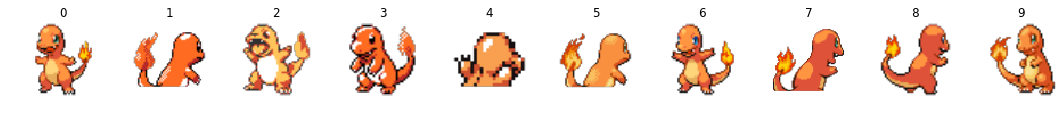

                                              pokemon dex_number normal  \
32  /home/tariq/PokemonTypeNN/data/dpp/charmander.png          4      0   
33  /home/tariq/PokemonTypeNN/data/gsc-back/charma...          4      0   
34  /home/tariq/PokemonTypeNN/data/rby/charmander.png          4      0   
35  /home/tariq/PokemonTypeNN/data/gsc/charmander.png          4      0   
36  /home/tariq/PokemonTypeNN/data/rby-back/charma...          4      0   
37  /home/tariq/PokemonTypeNN/data/rse-back/charma...          4      0   
38   /home/tariq/PokemonTypeNN/data/bw/charmander.png          4      0   
39  /home/tariq/PokemonTypeNN/data/dpp-back/charma...          4      0   
40  /home/tariq/PokemonTypeNN/data/bw-back/charman...          4      0   
41  /home/tariq/PokemonTypeNN/data/rse/charmander.png          4      0   

   fighting flying poison ground rock bug ghost steel fire water grass  \
32        0      0      0      0    0   0     0     0    1     0     0   
33        0      0      0 

In [44]:
def plot_all(dex_num, df):

    df_idxs = [i for i in range(0,len(df)) if df["dex_number"].iloc[i] == dex_num]
    print(df_idxs)
    fig = plt.figure(figsize=(15,15))
    labels = pd.DataFrame(columns=list(df))
    
    for i in range(0, len(df_idxs)):
        
        ax = plt.subplot(1, len(df_idxs), i+1)
        plt.tight_layout()
        ax.set_title(i)
        ax.axis("off")
        pkm_image = io.imread(df["pokemon"].iloc[ df_idxs[i] ])
        plt.imshow(pkm_image)
        print(np.array(pkm_image).shape)
        labels = labels.append(df.iloc[ df_idxs[i]])

    plt.show()
    return labels

#plot an example
temp_labels = plot_all(4,train_df)
print(temp_labels)

# Create the PokemonDataset (loads the project's Train/Test.csv formats)

inspiration: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [4]:
#TODO: Figure out how matrices are fed into pytorch

class PokemonDataset(Dataset):
    """Pokemon Dataset. """
    
    def __init__(self, csv_file_loc, transform=None):
        """
        Args:
            csv_file_loc (string): Path to the csv file
            transform (callable, optional): Optional transform to be applied to the sample
        
        """
        self.df = pd.read_csv(csv_file_loc)
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_name = self.df["pokemon"].iloc[index]
        
        image = io.imread(img_name)
        
        labels = self.df.iloc[index, 2:].as_matrix()
        #TODO: Do I need to reshape the labels?? Following makes labels a column instead of a row
        labels = labels.astype("float").reshape(len(labels))
        sample = {"image": image, "labels": labels}
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample, index
    
    def getpokemon(self, index):
        return self.df["pokemon"].iloc[index]

# Create Transformation Classes

In [5]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    
    def __call__(self, sample):
        image, labels = sample["image"], sample["labels"]
        
        #swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        
        image = image.transpose((2, 0, 1))
        return {"image": torch.from_numpy(image),
                "labels": torch.from_numpy(labels)}

# Load the Pokemon Datasets for the Neural Network

In [6]:
trainset = PokemonDataset(csv_file_loc = os.path.join(data_folder, "Train.csv"),
                         transform = transforms.Compose([ToTensor()]))
testset  = PokemonDataset(csv_file_loc = os.path.join(data_folder, "Test.csv" ),
                         transform = transforms.Compose([ToTensor()]))

trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                         shuffle=True,  num_workers=2)
testloader  = torch.utils.data.DataLoader(testset , batch_size=16,
                                         shuffle=False, num_workers=2)

classes = list(train_df)[2:]
print(classes)

['normal', 'fighting', 'flying', 'poison', 'ground', 'rock', 'bug', 'ghost', 'steel', 'fire', 'water', 'grass', 'electric', 'psychic', 'ice', 'dragon', 'dark', 'fairy']


# Test with some Training Images

/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


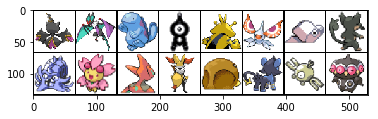

In [7]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

#get some random training images
dataiter = iter(trainloader)
minibatch, index = dataiter.next()
images, labels = minibatch["image"], minibatch["labels"]

#show images
imshow(torchvision.utils.make_grid(images))


# Define a Convolutional Neural Network!

In [27]:
# #Print if cuda is available
# print(torch.cuda.is_available())

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# # Assuming that we are on a CUDA machine, this should print a CUDA device:

# print(device)


In [26]:
# 
# check for multi-classification: https: //stackoverflow.com/questions/52855843/multi-label-classification-in-pytorch
# check for explanation of NN parameters: https://www.aiworkbox.com/lessons/how-to-define-a-convolutional-layer-in-pytorch
# check for reference model: https://nextjournal.com/gkoehler/pytorch-mnist
# loss function: BCELoss
# use sigmoid for multiple classes?

# Use THIS PAGE to calculate matrix outputs: https://pytorch.org/docs/stable/nn.html#torch.nn.MaxPool2d

# goal: convolve -> ReLu -> pool -> convolve -> ReLu -> pool -> Linear -> ReLu -> Linear -> ReLu -> Linear -> Sigmoid
# Loss function: BCELoss

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        #in_channels = number of colors (3), out_channels are the desired number to be learned, and 
        #kernel_size says whether to use nearby pixels  
        
        #TODO: remove stride in CNN (stride only later)
        # probably don't need so many linear layers
        # Add regularization
        # Do random shuffle to prpove that the network works
        
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size = 5, stride=2) # 6 output
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=18, kernel_size = 5, stride=2) #12 output
        self.fc1 = nn.Linear(in_features = 162, out_features= 120) #in_features=108
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 18)
        
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.shape[0], -1)
        #print(x.shape)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        return x
    
net = Net()
#net.cuda()

# Define a loss function and an optimizer

In [27]:
import torch.optim as optim

loss_fn = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Train the Network

In [37]:
max_epochs = 10

epochs_to_print = 100

for epoch in range(max_epochs):
    
    running_loss = 0.0
    
    for i, (minibatch, index) in enumerate(trainloader):
        #get the inputs
        images, labels = minibatch["image"], minibatch["labels"]
        images = images.float() #.cuda()
        labels = labels.float() #.cuda()
        
        
        #zero the parameter gradients
        optimizer.zero_grad()
        
        #forward + backward + optimize
        outputs = net(images) #net.forward()
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        
        #print statistics
        running_loss += loss.item()
        if i % epochs_to_print == epochs_to_print-1: #print every epochs_to_print mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / epochs_to_print))
            running_loss = 0.0
            

print("Finished training")

/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[1,   100] loss: 0.047
[1,   200] loss: 0.060


/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[2,   100] loss: 0.049
[2,   200] loss: 0.051


/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[3,   100] loss: 0.051
[3,   200] loss: 0.054


/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[4,   100] loss: 0.048
[4,   200] loss: 0.055


/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[5,   100] loss: 0.052
[5,   200] loss: 0.054


/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[6,   100] loss: 0.046
[6,   200] loss: 0.055


/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[7,   100] loss: 0.053
[7,   200] loss: 0.054


/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[8,   100] loss: 0.051
[8,   200] loss: 0.054


/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[9,   100] loss: 0.046
[9,   200] loss: 0.055


/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[10,   100] loss: 0.043
[10,   200] loss: 0.047
Finished training


# Test the Network

In [45]:
#Specify the loader
somevar = "train"

if(somevar == "train"):
    loader = trainloader
    theset = trainset
elif(somevar == "test"):
    loader = testloader
    theset = testset
else:
    raise ValueError("Please specify what to test on!")

In [46]:
class_correct = np.zeros(len(classes)) #array of number of times a class was successfully predicted
guessed_classes = np.zeros(len(classes)) #array of number of times a class was guessed
actual_class = np.zeros(len(classes)) #array of actual number of classes present in the test set

correct_pokemon = [] #list of Pokemon that were perfectly predicted 
pokemon_guesses = {} #dictionary of Pokemon and the NN's type guess
threshold = 0.5

with torch.no_grad():
    for i, (minibatch, index) in enumerate(loader):
        images, labels = minibatch["image"], minibatch["labels"]
        images = images.float()
        labels = labels.float()
        outputs = net(images)
        
        for j in range(images.shape[0]):
            
            #see which indices are above our threshold
            poss_indices = outputs[j] >= threshold
            
            #we haven't identified a type! pick the largest type as the prediction
            if(sum(poss_indices) < 1):
                big_class_index = np.argmax(outputs[j].numpy())
                outputs[j] = torch.zeros(outputs[j].shape, dtype=torch.uint8)
                outputs[j][big_class_index] = 1
                
            #there are too many types identified! Pick the largest two
            elif(sum(poss_indices) > 2):
                temp_outputs = outputs[j].numpy()
                big_class_index = np.argsort(temp_outputs)[-2:]
                outputs[j] = torch.zeros(outputs[j].shape, dtype=torch.uint8)
                outputs[j][big_class_index] = 1
                
            #only 1 or 2 classes beat the threshold! Set only those to 1; everything else to 0
            else:
                outputs[j] = torch.zeros(outputs[j].shape, dtype=torch.uint8)
                outputs[j][poss_indices] = 1
            
            #create a dictionary of Pokemon and the NN's prediction of its typing
            predicted_type = [classes[c] for c in range(len(classes)) if outputs[j][c] == 1]
            pokemon_guesses[theset.getpokemon(index.numpy()[j])] = predicted_type
            #print(theset.getpokemon(index.numpy()[j]), "\'s type :: ", predicted_type)
            
            
            #Gather NN stats
            numpy_labels  = labels[j].numpy()
            numpy_outputs = outputs[j].numpy()
            
            #number of Pokemon perfectly guessed by NN
            if(np.array_equal(numpy_labels, numpy_outputs)):
                correct_pokemon.append(theset.getpokemon(index.numpy()[j]))
            
            #number of classes present in the test set
            actual_class[numpy_labels == 1] += 1
            
            #counts the number of correctly identified classes
            #also counts the number of guessed classes by the NN
            for t in range(len(classes)):
                if numpy_labels[t] ==1 and numpy_outputs[t] == 1:
                    class_correct[t] += 1
                    
                if numpy_outputs[t] == 1:
                    guessed_classes[t] += 1
            
            
            
            
       # _, predicted = torch.max(outputs, 1)

         # following code is onlyl for single image identification
#         for j in range(images.shape[0]):
#             print(testset.getpokemon(index.numpy()[j])," \'s type:: ", classes[predicted[j]])
#             if(labels.numpy()[j][predicted[j]] == 1):
#                 class_correct[predicted[j]] = class_correct[predicted[j]]+1
#                 correct_pokemon.append(testset.getpokemon(index.numpy()[j]))
                
print("Correctly identified class percentage :: ", sum(class_correct)/sum(actual_class))
print("Ratio of Guessed Classes to Actual Classes :: ", sum(guessed_classes)/sum(actual_class))
print("Correctly identified Pokemon percentage :: ", len(correct_pokemon)/theset.__len__())
print("Perfectly identified Pokemon :: ")
for pkm in correct_pokemon:
    print(pkm, " :: ", pokemon_guesses[pkm])
#print("Random Guess accuracy :: ", (1/18))


/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Correctly identified class percentage ::  0.9074218142212541
Ratio of Guessed Classes to Actual Classes ::  0.9799284269488097
Correctly identified Pokemon percentage ::  0.8261866544370557
Perfectly identified Pokemon :: 
/home/tariq/PokemonTypeNN/data/gsc/chansey.png  ::  ['normal']
/home/tariq/PokemonTypeNN/data/bw-back/porygon2.png  ::  ['normal']
/home/tariq/PokemonTypeNN/data/bw/golduck.png  ::  ['water']
/home/tariq/PokemonTypeNN/data/dpp/spiritomb.png  ::  ['ghost', 'dark']
/home/tariq/PokemonTypeNN/data/dpp/giratina.png  ::  ['ghost', 'dragon']
/home/tariq/PokemonTypeNN/data/bw/deoxys.png  ::  ['psychic']
/home/tariq/PokemonTypeNN/data/bw-back/wormadamsandy.png  ::  ['ground', 'bug']
/home/tariq/PokemonTypeNN/data/dpp/yanmega.png  ::  ['flying', 'bug']
/home/tariq/PokemonTypeNN/data/bw-back/hippopotas.png  ::  ['ground']
/home/tariq/PokemonTypeNN/data/rse-back/zigzagoon.png  ::  ['normal']
/home/tariq/PokemonTypeNN/data/bw/snorlax.png  ::  ['normal']
/home/tariq/PokemonTypeNN/

/home/tariq/PokemonTypeNN/data/dpp-back/gyarados.png  ::  ['flying', 'water']
/home/tariq/PokemonTypeNN/data/bw-back/manaphy.png  ::  ['water']
/home/tariq/PokemonTypeNN/data/bw-back/cherrim.png  ::  ['grass']
/home/tariq/PokemonTypeNN/data/rby/exeggutor.png  ::  ['grass', 'psychic']
/home/tariq/PokemonTypeNN/data/bw/greninja.png  ::  ['water', 'dark']
/home/tariq/PokemonTypeNN/data/rse/miltank.png  ::  ['normal']
/home/tariq/PokemonTypeNN/data/dpp-back/tropius.png  ::  ['flying', 'grass']
/home/tariq/PokemonTypeNN/data/bw/munchlax.png  ::  ['normal']
/home/tariq/PokemonTypeNN/data/bw-back/dratini.png  ::  ['dragon']
/home/tariq/PokemonTypeNN/data/gsc/shellder.png  ::  ['water']
/home/tariq/PokemonTypeNN/data/bw-back/graveler.png  ::  ['ground', 'rock']
/home/tariq/PokemonTypeNN/data/bw/spritzee.png  ::  ['fairy']
/home/tariq/PokemonTypeNN/data/rse-back/feraligatr.png  ::  ['water']
/home/tariq/PokemonTypeNN/data/bw/onix.png  ::  ['ground', 'rock']
/home/tariq/PokemonTypeNN/data/bw-bac

/home/tariq/PokemonTypeNN/data/dpp/bayleef.png  ::  ['grass']
/home/tariq/PokemonTypeNN/data/dpp-back/spinda.png  ::  ['normal']
/home/tariq/PokemonTypeNN/data/rse-back/steelix.png  ::  ['ground', 'steel']
/home/tariq/PokemonTypeNN/data/rse/snubbull.png  ::  ['fairy']
/home/tariq/PokemonTypeNN/data/rse-back/hitmonchan.png  ::  ['fighting']
/home/tariq/PokemonTypeNN/data/dpp-back/pikachu.png  ::  ['electric']
/home/tariq/PokemonTypeNN/data/gsc/flaaffy.png  ::  ['electric']
/home/tariq/PokemonTypeNN/data/gsc/stantler.png  ::  ['normal']
/home/tariq/PokemonTypeNN/data/rby-back/tentacruel.png  ::  ['poison', 'water']
/home/tariq/PokemonTypeNN/data/rse/seel.png  ::  ['water']
/home/tariq/PokemonTypeNN/data/rby/moltres.png  ::  ['flying', 'fire']
/home/tariq/PokemonTypeNN/data/bw-back/arceusflying.png  ::  ['flying']
/home/tariq/PokemonTypeNN/data/rse-back/scizor.png  ::  ['bug', 'steel']
/home/tariq/PokemonTypeNN/data/dpp-back/charmeleon.png  ::  ['fire']
/home/tariq/PokemonTypeNN/data/rse-

In [41]:
rows = np.row_stack((actual_class, guessed_classes))
results_df = pd.DataFrame(rows, columns=classes)
results_df.insert(loc=0, column="Results", value=["Actual", "Guessed"])

print(results_df)

# print(classes)
# print("Actual classes :: ")
# print(actual_class)
# print("***********")
# print("Guessed classes :: ")
# print(guessed_classes)

   Results  normal  fighting  flying  poison  ground  rock   bug  ghost  \
0   Actual    50.0      34.0    42.0    14.0    24.0  20.0  44.0   18.0   
1  Guessed    26.0      12.0    52.0    25.0    41.0  25.0  16.0   16.0   

   steel  fire  water  grass  electric  psychic   ice  dragon  dark  fairy  
0   32.0  32.0   38.0   52.0      24.0     32.0  18.0    24.0  32.0    6.0  
1    7.0  30.0   70.0   34.0      15.0     49.0   6.0    15.0  21.0   12.0  


In [43]:
for key in pokemon_guesses:
    print(key, " :: ", pokemon_guesses[key])

/home/tariq/PokemonTypeNN/data/bw/victini.png  ::  ['fire']
/home/tariq/PokemonTypeNN/data/bw-back/victini.png  ::  ['flying']
/home/tariq/PokemonTypeNN/data/bw/snivy.png  ::  ['fighting']
/home/tariq/PokemonTypeNN/data/bw-back/snivy.png  ::  ['flying', 'grass']
/home/tariq/PokemonTypeNN/data/bw/servine.png  ::  ['flying', 'bug']
/home/tariq/PokemonTypeNN/data/bw-back/servine.png  ::  ['flying']
/home/tariq/PokemonTypeNN/data/bw/serperior.png  ::  ['fighting', 'grass']
/home/tariq/PokemonTypeNN/data/bw-back/serperior.png  ::  ['grass', 'psychic']
/home/tariq/PokemonTypeNN/data/bw/tepig.png  ::  ['flying', 'ghost']
/home/tariq/PokemonTypeNN/data/bw-back/tepig.png  ::  ['grass']
/home/tariq/PokemonTypeNN/data/bw/pignite.png  ::  ['flying', 'fire']
/home/tariq/PokemonTypeNN/data/bw-back/pignite.png  ::  ['water']
/home/tariq/PokemonTypeNN/data/bw/emboar.png  ::  ['normal']
/home/tariq/PokemonTypeNN/data/bw-back/emboar.png  ::  ['flying', 'fairy']
/home/tariq/PokemonTypeNN/data/bw/oshawott

In [32]:
# Test the train/test loader

for i in range(len(trainset)):
    sample = trainset[i]
    
    print(i, sample["image"].size(), sample["labels"].size())
    
    if(i == 3):
        break


0 torch.Size([3, 64, 64]) torch.Size([1, 18])
1 torch.Size([3, 64, 64]) torch.Size([1, 18])
2 torch.Size([3, 64, 64]) torch.Size([1, 18])
3 torch.Size([3, 64, 64]) torch.Size([1, 18])


/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [11]:
dic = {"a":[1,2,3,4],"b": "led", "c":10}
x, y, z = dic
print(x)

a


# Test the PokemonDataset

/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


0 (64, 64, 4) (1, 18)
[[0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0]]
1 (64, 64, 4) (1, 18)
[[0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0]]
2 (64, 64, 4) (1, 18)
[[0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0]]
3 (64, 64, 4) (1, 18)
[[0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0]]


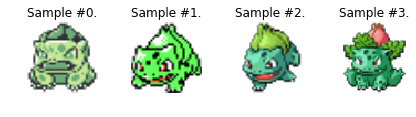

In [71]:
fig = plt.figure()

for i in range(len(trainset)):
    sample = trainset[i]
    
    print(i, sample["image"].shape, sample["labels"].shape)
    
    ax = plt.subplot(1, 4, i+1)
    plt.tight_layout()
    ax.set_title("Sample #{}.".format(i))
    ax.axis("off")
    plt.imshow(sample["image"])
    print(sample["labels"])
    
    if i == 3:
        plt.show()
        break